In [1]:
import sys
import os
import pandas as pd
import torch
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
import random
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from sklearn import preprocessing
from torchsummary import summary
import PIL.Image as Image
import torchvision.transforms as transforms
sys.path.insert(0, './network')
sys.path.insert(0, './loss_func')
sys.path.insert(0,'./dataloader')
from facedata_loader import load_filenames_array
from facedata_loader import ThumbnailDataloader
from facedata_loader import NumpyDataloader
from facedata_loader import rescalor_class
from network_functions_ import discriminator_conv
from network_functions_ import decay_gauss_std
from network_functions_ import generator_upsample

In [22]:
#for this to work just download and unzip facedata and put folder in same directory as this main file
#link: https://github.com/NVlabs/ffhq-dataset
#go to and download thumbnails 128 x 128, rename as required and you are good to go
root_dir='./Aura_photos/'
extension=('.JPEG', '.JPG')
thumbnails_locations = load_filenames_array(root_dir, extension)
thumbnails_locations = [location.replace('\\', '/')for location in thumbnails_locations]
print('length of dataset: ', len(thumbnails_locations))

length of dataset:  704


In [23]:
thumbnails_locations[:5]

['./Aura_photos/IMG_2815.JPEG',
 './Aura_photos/IMG_2816.JPEG',
 './Aura_photos/IMG_2817.JPEG',
 './Aura_photos/IMG_2818.JPEG',
 './Aura_photos/IMG_2819.JPEG']

In [24]:
thumbnails_location_df = pd.DataFrame(thumbnails_locations)
thumbnails_location_df.head()

0
0  ./Aura_photos/IMG_2815.JPEG
1  ./Aura_photos/IMG_2816.JPEG
2  ./Aura_photos/IMG_2817.JPEG
3  ./Aura_photos/IMG_2818.JPEG
4  ./Aura_photos/IMG_2819.JPEG

In [25]:
thumbnails_location_df.iloc[0].values[0]

'./Aura_photos/IMG_2815.JPEG'

In [26]:
rescalor_ = rescalor_class(-0.5, 0.5)
numpy_data_locations = []
#if numpy_data folder is not available in directory, just create a new folder and rename it as 'numpy_data' in same directory as this main file
root_npy = './numpy_data/'
#load image path into image, rescale and store in folder as numpy arrays
def image_to_numpy_data(thumbnails_locations_string_array, 
                        resize=(126, 126)):
    for idx, path_ in tqdm(enumerate(thumbnails_locations_string_array)):
        image_file = Image.open(path_)
        image_file = image_file.resize((resize[0], 
                        resize[1]), Image.ANTIALIAS)
        image_np = np.asarray(image_file)
        transposed_img = np.transpose(image_np, (2, 1, 0))
        #rescale
        transposed_img = np.expand_dims(transposed_img, axis=0)
        rescaled_image = rescalor_.rescale_image(transposed_img)#rescale data
        #print((rescaled_image).shape)
        np.save(root_npy+str(idx),np.squeeze(rescaled_image))
        #np.save(root_npy+str(idx),rescaled_image)
        numpy_data_locations.append(root_npy+str(idx)+'.npy')
image_to_numpy_data(thumbnails_locations)

704it [02:06,  5.58it/s]


In [27]:
def create_dummy_labels(
                        root_file,
                        data_size,
                        min_=0,
                        max_=1,
                        channel = 1,
                        height = 128,
                        width = 3
                       ):
    dummy_label_array = []
    for idx in range(data_size):
        latent_space = np.random.uniform(min_, max_, (1, height*width))
        np.save(root_file+str(idx), latent_space)
        dummy_label_array.append(root_file+str(idx)+'.npy')
    return dummy_label_array

In [28]:
label_location = './labels/'
label_locations_array = create_dummy_labels(label_location,
                                               len(thumbnails_locations))

In [29]:
len(numpy_data_locations)

704

In [30]:
len(label_locations_array)

704

In [31]:
np_location_df = pd.DataFrame(numpy_data_locations)
label_location_df = pd.DataFrame(label_locations_array)

In [32]:
np_location_df.to_csv('np_data.csv', index=False)
label_location_df.to_csv('label_data.csv', index=False)

In [2]:
np_location_df = pd.read_csv('np_data.csv')

In [3]:
label_location_df = pd.read_csv('label_data.csv')

In [4]:
train_set = np_location_df.iloc[:600,]
train_set_labels = label_location_df.iloc[:600,]

In [5]:
#load to a dataloader
train_loader = NumpyDataloader(train_set,
                              train_set_labels)#transform returning numpy to tensors

In [6]:
batch_size = 5
train_loader = DataLoader(train_loader, batch_size=batch_size,
                        shuffle=True, num_workers=0, drop_last=True)

In [7]:
#if saved_networks folder is not available in directory, just create a new folder and rename it as 'saved_networks' in same directory as this main file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def save_models(generator_network_model, discriminator_network_model):
    PATH = './saved_networks'
    torch.save(generator_network_model.state_dict(), os.path.join(PATH, "generator_model.pth"))
    torch.save(discriminator_network_model.state_dict(), os.path.join(PATH, "discriminator_model.pth"))
    
def load_models(generator_network_model, discriminator_network_model):
    PATH = './saved_networks'
    (generator_network_model.load_state_dict(torch.load(os.path.join(PATH, "generator_model.pth"),
                                                       map_location=device)))
    (discriminator_network_model.load_state_dict(torch.load(os.path.join(PATH, "discriminator_model.pth"),
                                                           map_location=device)))

# Conditional GAN architecture

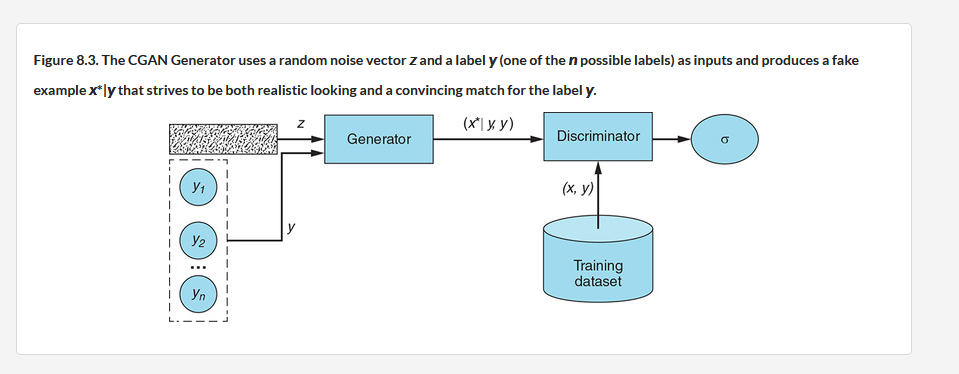
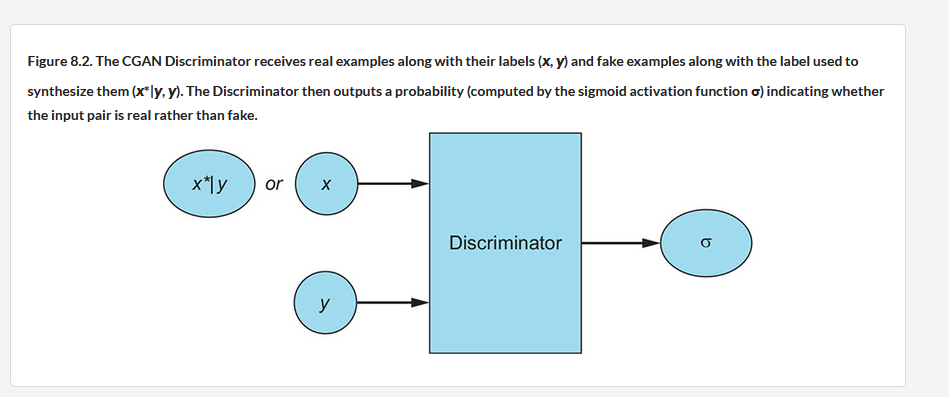


So we need:

- labels.

Our labels will be randomly generated values (temporarily) to help label the data coming in

In [8]:
epochs=500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator_network_model = discriminator_conv(hidden_channels = (6, 32, 64, 128, 256, 512, 1024),
                                                 label_vector_size = 384,
                                                 embedding_vector_size = 10,
                                                 total_epochs = epochs,
                                                 label_conditioning_linear_size = (3*126*126),
                                                 stride = 2,
                                                 kernel_size = 3)

In [9]:
discriminator_network_model

discriminator_conv(
  (leaf): Sequential(
    (0): Embedding(384, 10)
    (1): Linear(in_features=10, out_features=47628, bias=True)
  )
  (tree): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): Gaussian_noise()
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(256, eps=1e-05, 

In [10]:
summary(discriminator_network_model,  [(3 , 126, 126), (1,384)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 384, 47628]       --
|    └─Embedding: 2-1                    [-1, 1, 384, 10]          3,840
|    └─Linear: 2-2                       [-1, 1, 384, 47628]       523,908
├─Sequential: 1-2                        [-1, 1024, 22, 22]        --
|    └─Sequential: 2-3                   [-1, 32, 62, 62]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 62, 62]          1,760
|    |    └─Gaussian_noise: 3-2          [-1, 32, 62, 62]          --
|    |    └─LeakyReLU: 3-3               [-1, 32, 62, 62]          --
|    └─Sequential: 2-4                   [-1, 64, 30, 30]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 30, 30]          18,432
|    |    └─Gaussian_noise: 3-5          [-1, 64, 30, 30]          --
|    |    └─BatchNorm2d: 3-6             [-1, 64, 30, 30]          128
|    |    └─LeakyReLU: 3-7               [-1, 64, 30, 30]          --

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 384, 47628]       --
|    └─Embedding: 2-1                    [-1, 1, 384, 10]          3,840
|    └─Linear: 2-2                       [-1, 1, 384, 47628]       523,908
├─Sequential: 1-2                        [-1, 1024, 22, 22]        --
|    └─Sequential: 2-3                   [-1, 32, 62, 62]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 62, 62]          1,760
|    |    └─Gaussian_noise: 3-2          [-1, 32, 62, 62]          --
|    |    └─LeakyReLU: 3-3               [-1, 32, 62, 62]          --
|    └─Sequential: 2-4                   [-1, 64, 30, 30]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 30, 30]          18,432
|    |    └─Gaussian_noise: 3-5          [-1, 64, 30, 30]          --
|    |    └─BatchNorm2d: 3-6             [-1, 64, 30, 30]          128
|    |    └─LeakyReLU: 3-7               [-1, 64, 30, 30]          --

In [11]:
generator_network_model = generator_upsample(latent_dim_in = 10,
                                            latent_dim_out = 1023*4*4,
                                            conditioning_dim_out = 1*4*4,
                                            conditioning_dim_out_e = 100,
                                            conditioning_dim_in_e= 384,
                                            conditioning_dim_in = 100, 
                                            kernel_size_head = 2,
                                            stride_head = 1,
                                            hidden_channels=(1024, 512, 256, 128, 64, 32),
                                            upsample_body_factor = 2).to(device)

In [12]:
generator_network_model

generator_upsample(
  (label_conditioning): Sequential(
    (0): Embedding(384, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent_conditioning): Sequential(
    (0): Linear(in_features=10, out_features=16368, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (main_head): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (upsample_body): Sequential(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(1024, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Dropout2d(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
   

In [13]:
summary(generator_network_model,  [(1,10), (1,384)])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 16368]            --
|    └─Linear: 2-1                       [-1, 1, 16368]            180,048
|    └─LeakyReLU: 2-2                    [-1, 1, 16368]            --
├─Sequential: 1-2                        [-1, 1, 384, 16]          --
|    └─Embedding: 2-3                    [-1, 1, 384, 100]         38,400
|    └─Linear: 2-4                       [-1, 1, 384, 16]          1,616
├─Sequential: 1-3                        [-1, 1024, 3, 3]          --
|    └─Conv2d: 2-5                       [-1, 1024, 3, 3]          4,194,304
|    └─BatchNorm2d: 2-6                  [-1, 1024, 3, 3]          2,048
|    └─LeakyReLU: 2-7                    [-1, 1024, 3, 3]          --
├─Sequential: 1-4                        [-1, 32, 127, 127]        --
|    └─Sequential: 2-8                   [-1, 512, 7, 7]           --
|    |    └─Upsample: 3-1                [-1, 1024, 6, 6]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 16368]            --
|    └─Linear: 2-1                       [-1, 1, 16368]            180,048
|    └─LeakyReLU: 2-2                    [-1, 1, 16368]            --
├─Sequential: 1-2                        [-1, 1, 384, 16]          --
|    └─Embedding: 2-3                    [-1, 1, 384, 100]         38,400
|    └─Linear: 2-4                       [-1, 1, 384, 16]          1,616
├─Sequential: 1-3                        [-1, 1024, 3, 3]          --
|    └─Conv2d: 2-5                       [-1, 1024, 3, 3]          4,194,304
|    └─BatchNorm2d: 2-6                  [-1, 1024, 3, 3]          2,048
|    └─LeakyReLU: 2-7                    [-1, 1024, 3, 3]          --
├─Sequential: 1-4                        [-1, 32, 127, 127]        --
|    └─Sequential: 2-8                   [-1, 512, 7, 7]           --
|    |    └─Upsample: 3-1                [-1, 1024, 6, 6]      

In [14]:
@torch.no_grad()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [15]:
#generator_network_model.apply(weights_init)
generator_network_model.apply(weights_init)

generator_upsample(
  (label_conditioning): Sequential(
    (0): Embedding(384, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent_conditioning): Sequential(
    (0): Linear(in_features=10, out_features=16368, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (main_head): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (upsample_body): Sequential(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(1024, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
      (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Dropout2d(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
   

In [16]:
discriminator_network_model.apply(weights_init)

discriminator_conv(
  (leaf): Sequential(
    (0): Embedding(384, 10)
    (1): Linear(in_features=10, out_features=47628, bias=True)
  )
  (tree): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): Gaussian_noise()
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): Gaussian_noise()
      (2): BatchNorm2d(256, eps=1e-05, 

In [17]:
mean_ = 0
sigma_ = 0.5
l_ = np.random.uniform(0, 1, (1, 1, 384))#label
l__ = np.random.normal(mean_, sigma_, (1, 1, 10))#latent
generated_image = generator_network_model(l__,
                        l_)

In [18]:
generated_image.shape

torch.Size([1, 3, 126, 126])

In [19]:
discriminator_network_model(generated_image, l_)

tensor([[0.2203]], grad_fn=<AddmmBackward0>)

In [20]:
#lr = 5e-5
#optimizer_generator = torch.optim.RMSprop(generator_network_model.parameters(),lr=lr)
#optimizer_critic = torch.optim.RMSprop(discriminator_network_model.parameters(),lr=lr)
lr = 2e-4
beta = (0.5, 0.999)
optimizer_generator = torch.optim.Adam(generator_network_model.parameters(),lr=lr, betas = beta)
optimizer_critic = torch.optim.Adam(discriminator_network_model.parameters(),lr=lr, betas = beta)
clip = 0.01
t_critic = 1

In [21]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().detach().cpu().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
device
criterion = torch.nn.BCEWithLogitsLoss()
#https://machinelearningmastery.com/generative-adversarial-network-loss-functions/

In [ ]:
discriminator_loss_array = []
generator_loss_array_ = []
lr_array_generator=[]
lr_array_critic = []
test_label = None
for epoch in range(epochs):
    for i, data in tqdm(enumerate(train_loader)):
        #print(data[0].shape)
        min_ = 0
        max_ = 1
        test_label = data[1]
        latent_space = np.random.uniform(min_, max_, (batch_size,1,10))
            #scores real
        discriminator_scores_reals = \
                discriminator_network_model(data[0].float().to(device),
                                           data[1].type(torch.LongTensor).to(device))
        dicriminator_real_loss = criterion(discriminator_scores_reals,
                torch.empty_like(discriminator_scores_reals).uniform_(0.8, 0.9).to(device))
            #scores fake  
        discriminator_scores_fakes = \
                discriminator_network_model(generator_network_model(latent_space,
                                                data[1].type(torch.LongTensor).to(device)),
                                           data[1].type(torch.LongTensor).to(device))
        
        
        
        discriminator_fake_loss = criterion(discriminator_scores_fakes,
                torch.empty_like(discriminator_scores_fakes).uniform_(0.0, 0.1).to(device))
        
        total_discriminator_loss = discriminator_fake_loss + dicriminator_real_loss
        optimizer_critic.zero_grad()
        total_discriminator_loss.backward()
        optimizer_critic.step()
        discriminator_loss_array.append(total_discriminator_loss.mean().item())
        
        
        if i % t_critic == 0:
            plot_grad_flow(discriminator_network_model.named_parameters())
            mean_ = 0
            sigma_ = 1
            latent_space = np.random.uniform(min_, max_, (batch_size,1,10))
            D_out = discriminator_network_model(generator_network_model(
                                                                latent_space,
                                                                data[1].type(torch.LongTensor).to(device)),
                                               data[1].type(torch.LongTensor).to(device))
            generator_loss = criterion(D_out,
                    torch.ones_like(D_out).float().to(device))
            optimizer_generator.zero_grad()
            generator_loss.backward(retain_graph=True)
            optimizer_generator.step()
            generator_loss_array_.append(generator_loss.mean().item())
    decay_gauss_std(discriminator_network_model)
    lr_array_generator.append(optimizer_generator.param_groups[0]["lr"])
    lr_array_critic.append(optimizer_critic.param_groups[0]["lr"])

3it [00:08,  2.85s/it]

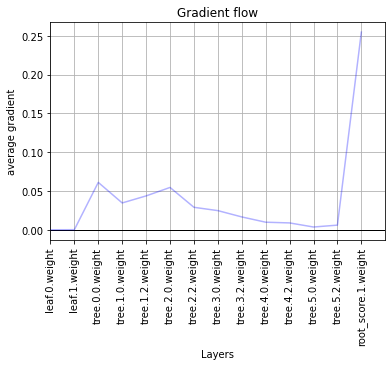

In [24]:
plot_grad_flow(discriminator_network_model.named_parameters())

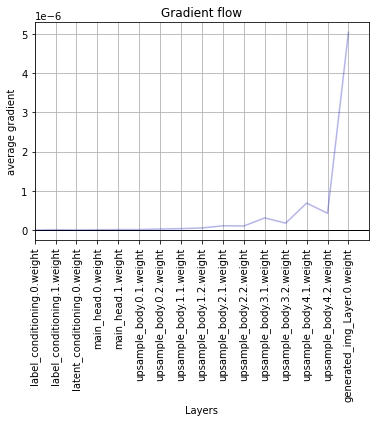

In [25]:
plot_grad_flow(generator_network_model.named_parameters())

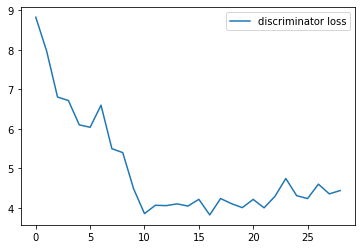

In [26]:
discriminator_loss_array
from scipy.ndimage.filters import uniform_filter1d
from matplotlib import pyplot as plt
arr = uniform_filter1d(discriminator_loss_array, size=10)
a=[]
y=[]
for i, e in enumerate(arr):
    y.append(i)
    a.append(e)
plt.plot(y, a,label='discriminator loss')
plt.legend()
plt.show()

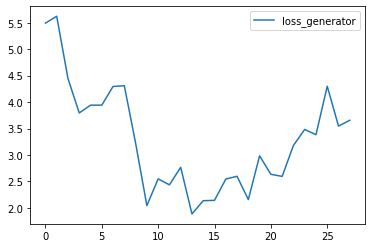

In [27]:
generator_loss_array_
arr = uniform_filter1d(generator_loss_array_, size=10)
c=[]
y=[]
for i, e in enumerate(arr):
    y.append(i)
    c.append(e)


plt.plot(y, c,label='loss_generator')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 1, 384])


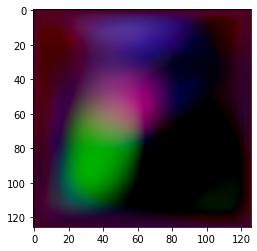

torch.Size([5, 1, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


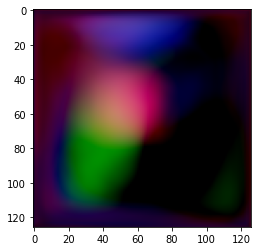

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 1, 384])


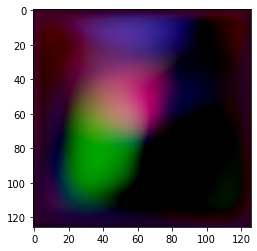

In [28]:
for i in range(3):
    min_ = 0
    max_ = 1
    latent_ = np.random.uniform(min_, max_, (1,10))
    print(test_label.shape)
    label_ = test_label[-1,:,:]
    label_ = label_.unsqueeze(0)
    with torch.no_grad():
        fake = generator_network_model(latent_,
                                      label_)
    fake = fake.detach().cpu().numpy() #create fake sample
    fake_ = np.squeeze(fake)
    fake_ = np.transpose(fake_, (2, 1, 0))
    plt.imshow(fake_)
    plt.show()

In [ ]:
save_models(generator_network_model, discriminator_network_model)

In [ ]:
load_models(generator_network_model, discriminator_network_model)

In [ ]:
plt.imshow(fake_)